In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [5]:
songs = pd.read_csv('./data/five_genres_500_samp.csv')

In [6]:
X = songs._get_numeric_data().drop(columns=['key', 'mode'])
y = songs['genre']

In [11]:
def running_models(X, y, scaled=False, c=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    
    # MODELING WITH SCALED FEATURES #
    
    # Scale the features
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # Creating a df to display results
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model_sc = SVC(C=c, kernel='rbf', degree=3)
    model_sc.fit(X_train_sc, y_train)
    train_score = model_sc.score(X_train_sc, y_train)
    test_score = model_sc.score(X_test_sc, y_test)
    
    row = {'model': type(model_sc).__name__,
           'train_score' : train_score,
          'test_score' : test_score,
           'C': c,
          'scaled': True}
    model_df = model_df.append(row, ignore_index=True)
    
    # MODELING WITH UNSCALED FEATURES #
    
    model = SVC(C=20000, kernel='rbf', degree=3)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
       'train_score' : train_score,
      'test_score' : test_score,
       'C': 20000,
      'scaled': False}
    model_df = model_df.append(row, ignore_index=True)
    return model_df

In [12]:
running_models(X, y)

,train_score,test_score,C,model,scaled
0,0.833067,0.7824,10.0,SVC,1.0
1,0.755733,0.7568,20000.0,SVC,0.0


Using Spotify's shared features, **the model has an accuracy of $\approx$ 78.2%**. This is the baseline to beat!

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [24]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [25]:
model = SVC(C=10, kernel='rbf')

In [26]:
model.fit(X_train_sc, y_train)

SVC(C=10)

In [27]:
model.score(X_train_sc, y_train)

0.8330666666666666

In [28]:
model.score(X_test_sc, y_test)

0.7824

In [29]:
y_preds = model.predict(X_test_sc)

In [30]:
results = X_test.copy()

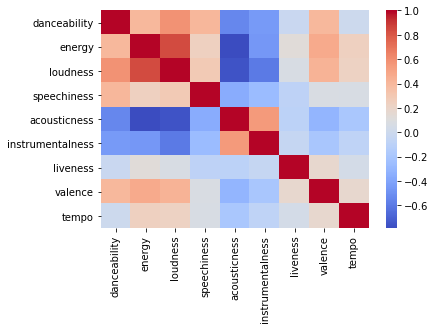

In [31]:
sns.heatmap(results.corr(), cmap='coolwarm');

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [32]:
results.loc[:, 'genre'] = y_test.copy()

In [33]:
results.loc[:, 'preds'] = y_preds.copy()

In [34]:
results_wrong = results[results['genre'] != results['preds']]

In [35]:
results_wrong['genre'].value_counts(normalize=True)

r&b                      0.316176
rap                      0.286765
rock                     0.220588
progressive bluegrass    0.117647
classical                0.058824
Name: genre, dtype: float64

**Rap and R&B seem to be predicted wrong** most often based on the features Spotify has pulled from the music.

In [36]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

r&b     0.974359
rock    0.025641
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as **R&B about 89.1% of the time.**

In [37]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

rap                      0.720930
progressive bluegrass    0.162791
rock                     0.116279
Name: preds, dtype: float64

R&B is most likely to be predicted as rap, **but only 47.3% of the time.**

In [38]:
genre_mean = songs.groupby('genre').mean()

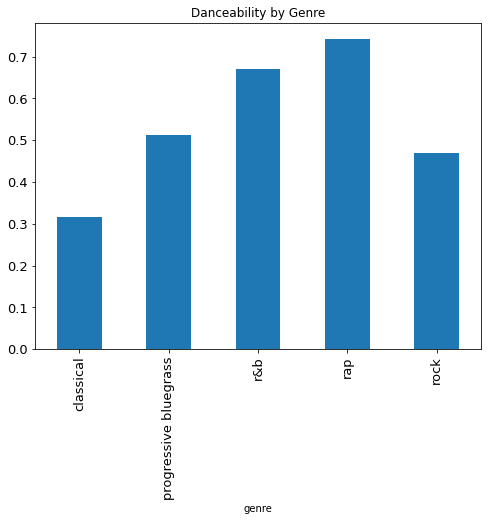

In [45]:
genre_mean['danceability'].plot(kind='bar', fontsize=13, figsize=(8, 6))
plt.title('Danceability by Genre');

It looks like Rap has the highest danceability at over 0.7, Classical has the lowest danceability at just above 0.3.

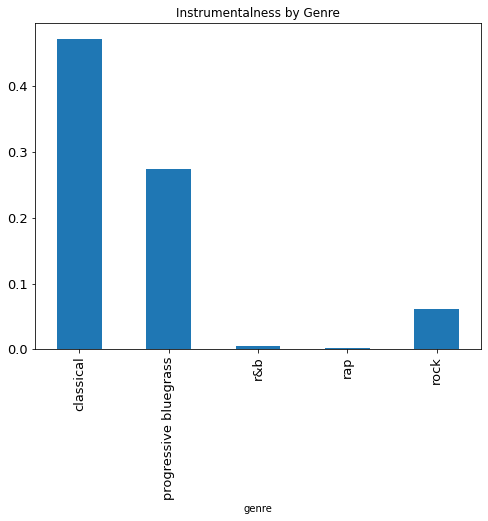

In [46]:
genre_mean['instrumentalness'].plot(kind='bar', fontsize=13, figsize=(8, 6))
plt.title('Instrumentalness by Genre');

Classical has the highest instrumentalness, while rap has the lowest

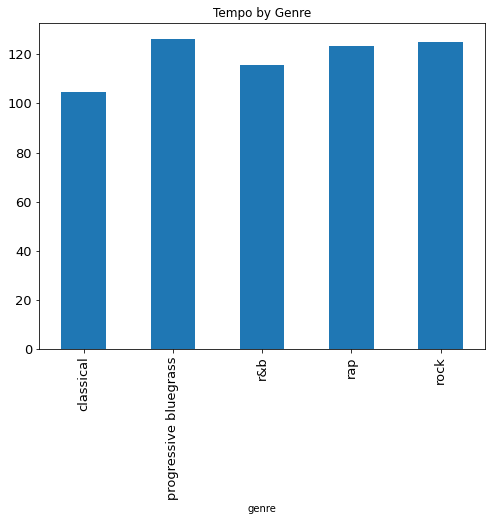

In [47]:
genre_mean['tempo'].plot(kind='bar', fontsize=13, figsize=(8, 6))
plt.title('Tempo by Genre');

Interesting that most of the genres hover slightly above 120 as a tempo. There's some interesting reasoning behind this with commercial music and the need for 30-seconds of music to fill an advertising slot. 128 beats per minute would allow for a 16-bar phrase in 4/4 time, which is a common way of writing a full musical phrase.

## What's next?

Now that we've seen how accurate a model is with Spotify's features and 5-genres, let's add some of the new genres to the mix.